# <center> Data Wrangling and EDA</center>

## Import packages

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
import cv2

In [2]:
%run "../scripts/image_saving.py"

## Load the data
Before loading the data, we will check for corrupt or unusually small images, we will remove any image smaller than 50x50 pixels.

In [3]:
train_dir = '../data/raw/Training'
test_dir = '../data/raw/Testing'

In [4]:
def check_image_size(image_path):
    try:
        img = Image.open(image_path)
        # Check if image size is smaller than 50x50 pixels
        if img.size[0] < 50 or img.size[1] < 50:  
            print(f"Image too small: {image_path}")
            return False
    except Exception as e:
        print(f"Corrupted image: {image_path}")
        return False
    return True

In [5]:
img_list=[]
for folder in [train_dir, test_dir]:
    for class_folder in os.listdir(os.path.join(folder)):
        for image_file in os.listdir(os.path.join(folder, class_folder)):
            test = check_image_size(os.path.join(folder, class_folder, image_file))
            if not test:
               img_list.append(os.path.join(folder, class_folder, image_file)) 

We then remove any identified corrupted image

In [6]:
for path in img_list:
    os.remove(path)

Let's check image dimension before loading the data

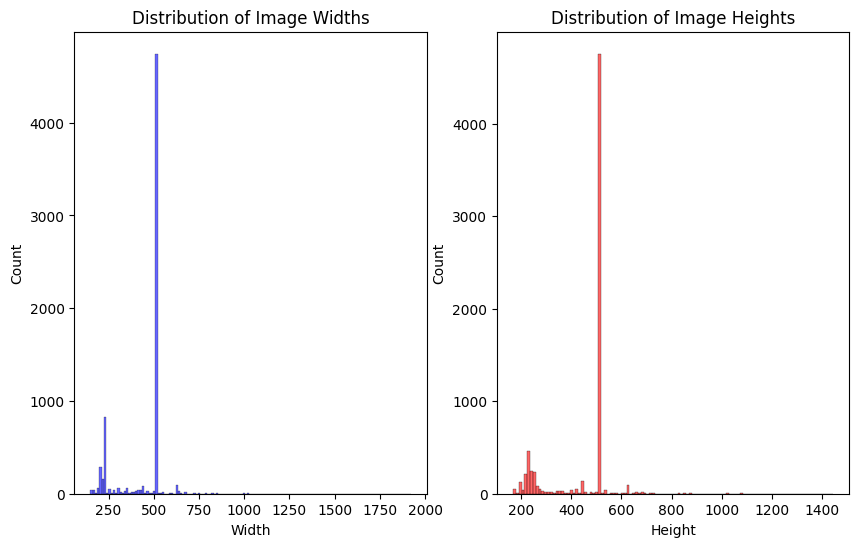

In [7]:
image_sizes = []
for folder in [train_dir, test_dir]:
    for class_folder in os.listdir(os.path.join(folder)):
        for image_file in os.listdir(os.path.join(folder, class_folder)):
            img = Image.open(os.path.join(folder, class_folder, image_file))
            image_sizes.append(img.size)

image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])


plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
sns.histplot(image_sizes_df['Width'], label='Width', color='blue', alpha=0.6)
plt.title('Distribution of Image Widths')
plt.subplot(1,2,2)
sns.histplot(image_sizes_df['Height'], label='Height', color='red', alpha=0.6)
plt.title('Distribution of Image Heights')
plt.show()

Images have different dimensions, we should consider resizing them.  

In [8]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=32,         
    label_mode='categorical',
    shuffle = False
)


test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=32,          
    label_mode='categorical',
    shuffle=False                
)

for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


## Class distribution
Let's check class distribution in the training and test sets

Class distribution in the Training set:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}


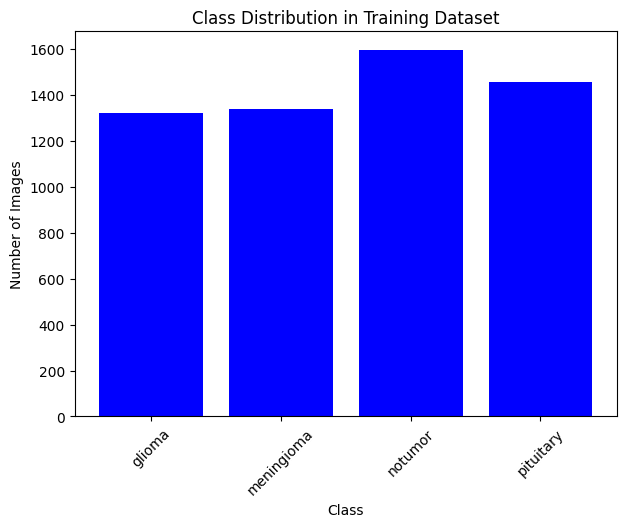

In [9]:
class_names = train_dataset.class_names


all_labels = []

for _, labels in train_dataset.unbatch():
    label_indices = np.argmax(labels.numpy(), axis=-1) 
    all_labels.append(label_indices)

class_frequencies = np.bincount(all_labels)
labelled_frequencies = dict(zip(class_names,class_frequencies.tolist()))
print("Class distribution in the Training set:")
print(labelled_frequencies)

plt.figure(figsize=(7, 5))
plt.bar(class_names, class_frequencies, color='blue')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

Class distribution in the test set:
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


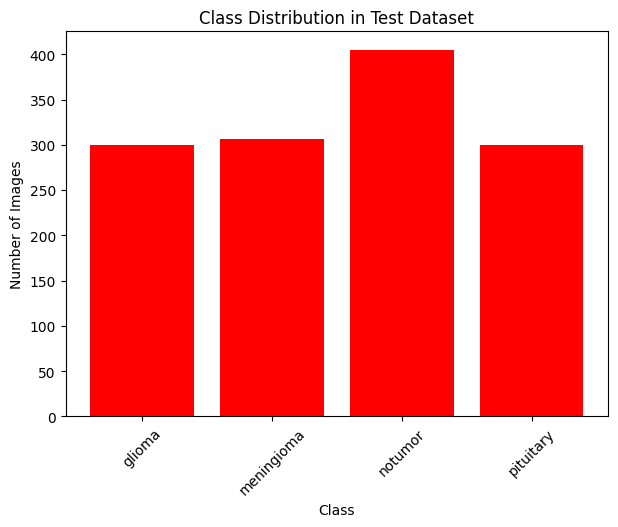

In [10]:
all_labels = []

for _, labels in test_dataset.unbatch():
    label_indices = np.argmax(labels.numpy(), axis=-1) 
    all_labels.append(label_indices)

class_frequencies = np.bincount(all_labels)
labelled_frequencies = dict(zip(class_names,class_frequencies.tolist()))
print("Class distribution in the test set:")
print(labelled_frequencies)

plt.figure(figsize=(7, 5))
plt.bar(class_names, class_frequencies, color='red')
plt.title("Class Distribution in Test Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

The dataset can be considered relatively balanced, with the "no-Tumor" class having a slightly higher number of images compared to the other classes.

While the dataset is not severely imbalanced, there is still a slight imbalance because the sample sizes for the classes differ by around 15%.

## Image visualization
We propose to visualize a sample of images from different classes in the dataset.

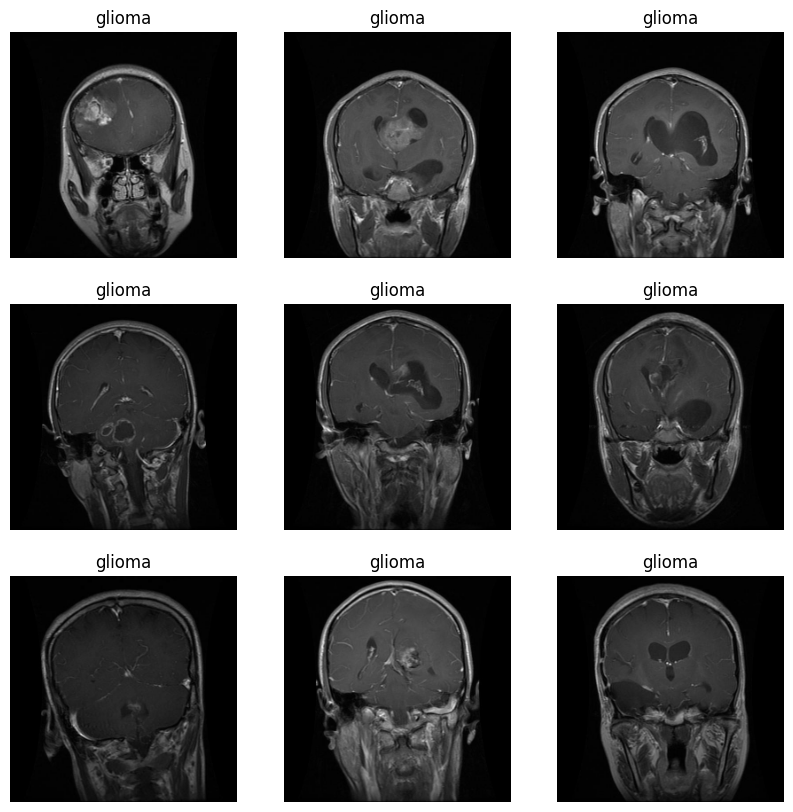

In [11]:
image_batch, label_batch = next(iter(train_dataset))
image_batch = image_batch / 255.0
plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):  
    plt.subplot(3, 3, i+1)  
    plt.imshow(image_batch[i])  
    plt.title(class_names[tf.argmax(label_batch[i])])  
    plt.axis('off')
plt.show()

## Image Brightness
To calculate brightness in images,  we converted the image to grayscale and compute the mean brightness per class.

In [12]:
def compute_brightness_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    brightness = tf.reduce_mean(grayscale_image)
    return brightness

def get_class_brightness(dataset):
    class_brightness = {class_name: [] for class_name in dataset.class_names}

    for images, labels in dataset:
        for i, image in enumerate(images):
            brightness = compute_brightness_grayscale(image)
            
            class_index = tf.argmax(labels[i]).numpy()  
            class_name = dataset.class_names[class_index]
            
            class_brightness[class_name].append(brightness.numpy())

    avg_brightness_per_class = {
        class_name: np.mean(class_brightness[class_name]) 
        for class_name in class_brightness
    }

    return avg_brightness_per_class

Train Class Brightness: {'glioma': np.float32(32.40414), 'meningioma': np.float32(43.109093), 'notumor': np.float32(60.35658), 'pituitary': np.float32(48.82628)}
Test Class Brightness: {'glioma': np.float32(33.68228), 'meningioma': np.float32(52.068726), 'notumor': np.float32(58.710167), 'pituitary': np.float32(47.09034)}


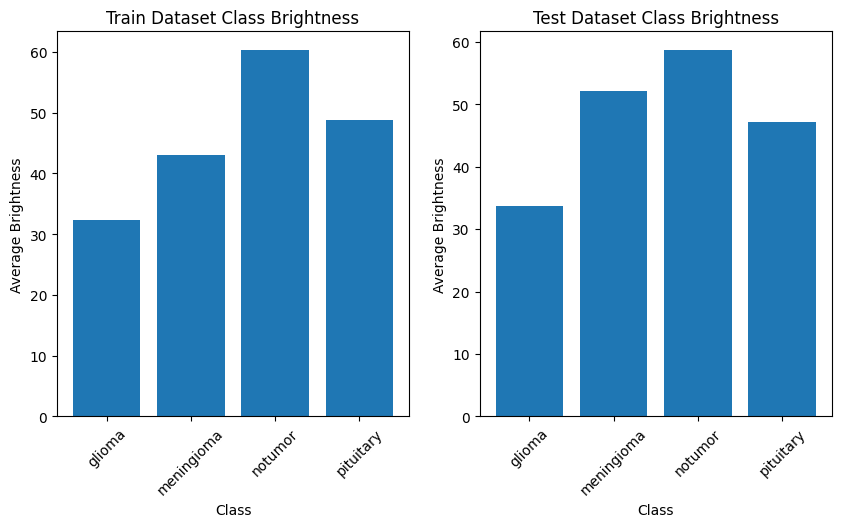

In [13]:
train_class_brightness = get_class_brightness(train_dataset)
print("Train Class Brightness:", train_class_brightness)

test_class_brightness = get_class_brightness(test_dataset)
print("Test Class Brightness:", test_class_brightness)

def plot_brightness(brightness_dict, title="Class Brightness"):
    classes = list(brightness_dict.keys())
    brightness_values = list(brightness_dict.values())

    plt.bar(classes, brightness_values)
    plt.xlabel('Class')
    plt.ylabel('Average Brightness')
    plt.title(title)
    plt.xticks(rotation=45)
   

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plot_brightness(train_class_brightness, "Train Dataset Class Brightness")
plt.subplot(1,2,2)
plot_brightness(test_class_brightness, "Test Dataset Class Brightness")
plt.show()

Images with glioma tumor tend to be darker than the others. We then plot the histograms of brightness values for each class to see the distribution of brightness within each class.

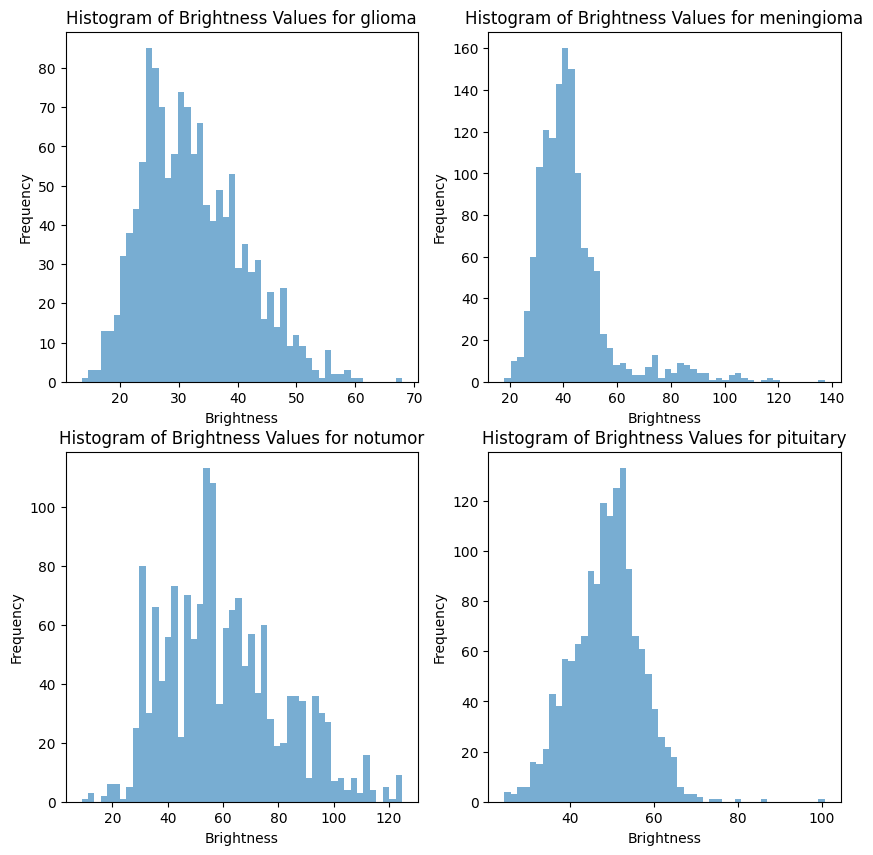

In [14]:
class_brightness = {class_name: [] for class_name in class_names}

for images, labels in train_dataset:
    for i, image in enumerate(images):
        brightness = compute_brightness_grayscale(image)
            
        class_index = tf.argmax(labels[i]).numpy()
        class_name = train_dataset.class_names[class_index]
            
        class_brightness[class_name].append(brightness.numpy())

plt.figure(figsize=(10, 10))
for class_name, brightness_values in class_brightness.items():
    plt.subplot(2, 2, train_dataset.class_names.index(class_name)+1)
    plt.hist(brightness_values, bins=50, alpha=0.6)
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.title('Histogram of Brightness Values for '+class_name)

plt.show()

Images in the meningioma and pituitary classes exhibit low contrast. Poor contrast makes the edges and boundaries of structures (brain tissues or tumors) less defined, which can affect feature extraction. We should consider applying contrast enhancement techniques in the preprocessing step.

## Image quality
To check if there are any blurred images in the dataset, we measure the sharpness or clarity of an image. We use the Laplacian operator, which calculates the second derivative of an image, and measure its variance. A low variance of the Laplacian suggests that the image is blurred, while a high variance indicates that the image is sharp.

In [15]:
def compute_sharpness(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    
    grayscale_image_np = grayscale_image.numpy().astype(np.uint8)

    laplacian = cv2.Laplacian(grayscale_image_np, cv2.CV_64F)

    variance = laplacian.var()
    
    return variance

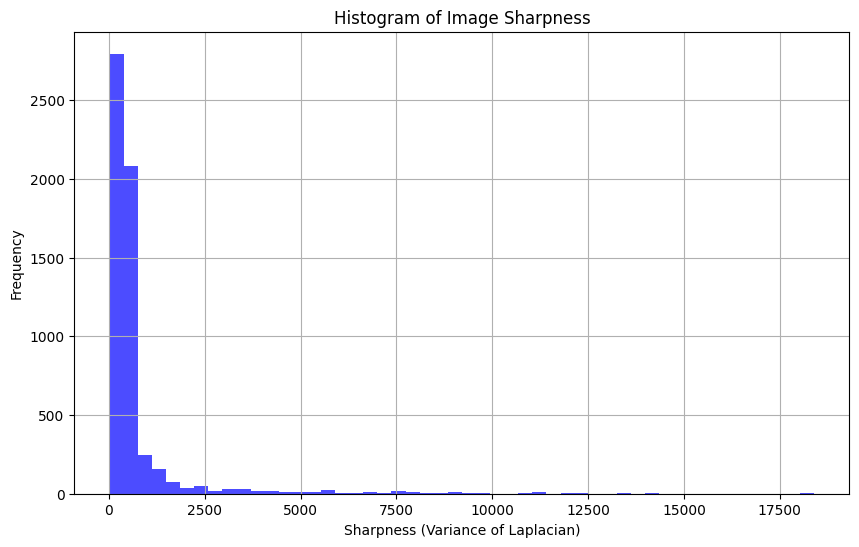

In [16]:
sharpness_values = []
for images, _ in train_dataset:
    for image in images:
        sharpness = compute_sharpness(image)
        sharpness_values.append(sharpness)

plt.figure(figsize=(10, 6))
plt.hist(sharpness_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Image Sharpness')
plt.xlabel('Sharpness (Variance of Laplacian)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
def check_blurred_images(dataset):
    
    blurred_images_index = []
    
    for images, labels in dataset:
        for i, image in enumerate(images):
            variance = compute_sharpness(image)
            
            if variance < 100:
                blurred_images_index.append(i)
                  
    
    print(f"Number of blurred images: {len(blurred_images_index)}")
    
    return blurred_images_index

Number of blurred images: 78


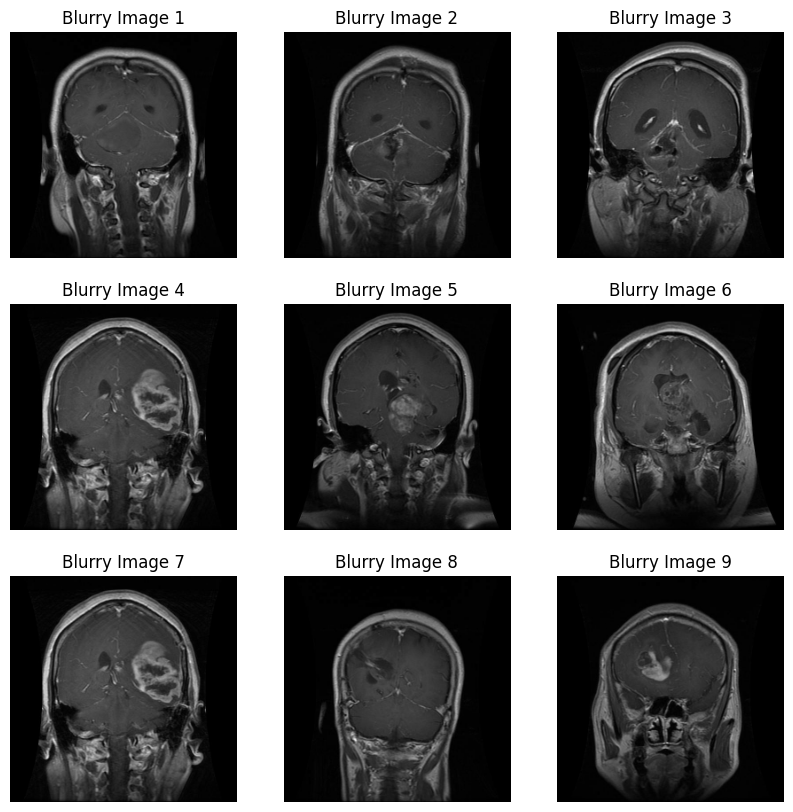

In [18]:
train_blurred_images_index = check_blurred_images(train_dataset)


image_list = []
for images, _ in train_dataset:
    image_list.extend(images.numpy())
    
plt.figure(figsize=(10, 10))
for i, idx in enumerate(train_blurred_images_index[:9]):  
    image = image_list[idx]  
    plt.subplot(3, 3, i+1)
    plt.imshow(image/255.0)
    plt.axis('off')
    plt.title(f"Blurry Image {i+1}")
plt.show()

The quality of the detected blurred images is satisfactory, so we have decided to retain all the images in the dataset.

## Save the dataset to a TFRecord file

In [19]:
write_to_tfrecord(train_dataset, '../data/interim/train_data.tfrecord')
write_to_tfrecord(test_dataset, '../data/interim/test_data.tfrecord')